# Optimization NN in TensorFlow

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import layers

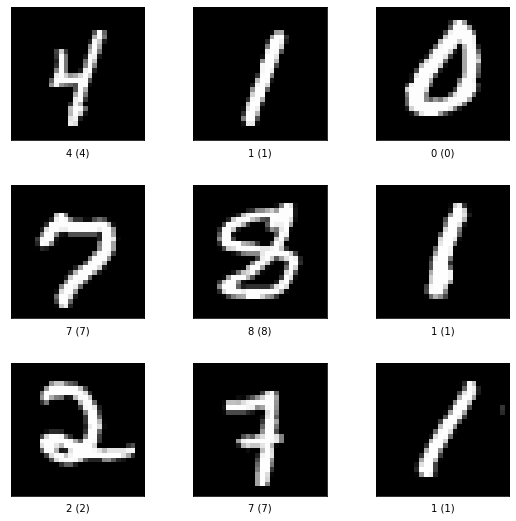

<_OptionsDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [2]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    name = 'mnist',
    split=['train[:30%]', 'test[:30%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)
fig = tfds.show_examples(ds_train_mnist, ds_info_mnist)
print(ds_train_mnist)

In [4]:
trainprocess = tf.keras.Sequential([                
        layers.Rescaling(scale=1.0 / 255.)
    ],name='preprocess')

def one_hot(dx,dy):
    return trainprocess(dx), tf.one_hot(
    dy, 10)
Batch=32
def data_load_sequential(data_ds,shuffle_train=True ,batch_=Batch):
    data_ds=data_ds.map(one_hot)
    data_ds = data_ds.cache()
    if shuffle_train:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

data_train_mnist = data_load_sequential(ds_train_mnist)
data_test_mnist = data_load_sequential(ds_test_mnist,shuffle_train=False)
for ds,lb in data_train_mnist.take(1):
    print(ds.shape,lb.shape)
shaped_mnist=ds[0].numpy().shape

(32, 28, 28, 1) (32, 10)


In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=shaped_mnist))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
__________________________________________________

In [6]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor="val_loss", mode="min"),
    tf.keras.callbacks.ModelCheckpoint(filepath='carpeta_resultados_/model.h5',monitor='val_loss',\
                                       save_best_only=True ,mode='min' ),
    tf.keras.callbacks.TensorBoard(log_dir='carpeta_resultados/logs', histogram_freq=1),
]

In [7]:
model.compile(loss='CategoricalCrossentropy',
              optimizer='adam',metrics=['accuracy'])

In [8]:
Epochs=5
history=model.fit(data_train_mnist,validation_data=data_test_mnist, epochs=Epochs,verbose=1, callbacks=my_callbacks)

Epoch 1/5
563/563 [==============================] - 10s 15ms/step - loss: 0.3195 - accuracy: 0.9061 - val_loss: 0.1261 - val_accuracy: 0.9597
Epoch 2/5
563/563 [==============================] - 8s 14ms/step - loss: 0.1048 - accuracy: 0.9691 - val_loss: 0.0778 - val_accuracy: 0.9750
Epoch 3/5
563/563 [==============================] - 8s 15ms/step - loss: 0.0682 - accuracy: 0.9797 - val_loss: 0.0836 - val_accuracy: 0.9720
Epoch 4/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.0936 - val_accuracy: 0.9680


In [9]:
model.evaluate(data_test_mnist)

94/94 [==============================] - 1s 6ms/step - loss: 0.0936 - accuracy: 0.9680


[0.09356950223445892, 0.9679999947547913]

In [10]:
import os

In [11]:
(os.path.getsize('carpeta_resultados_/model.h5'))/float(2**20)

4.006011962890625

# Prunning

In [12]:
import tensorflow_model_optimization as tfmot

In [14]:
step =np.ceil(len(data_train_mnist)/Batch)

In [16]:
prunning_params = {
   'prunning_schedule':tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity= 0.5,
    begin_step= step*Batch,
    end_step =step*Batch*5
   )}

In [17]:
model_for_prunning = tfmot.sparsity.keras.prune_low_magnitude(model, **prunning_params)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
model_for_prunning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_flatten  (None, 5408)             1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense (  (None, 64)               692290    
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dense_1  (None, 10)               1

In [19]:
model_for_prunning.compile(loss='CategoricalCrossentropy',
              optimizer='adam',metrics=['accuracy'])

In [20]:
callback_prunning=[
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='carpeta_resultados/log_prunning/')
]

In [21]:
model_for_prunning.fit(data_train_mnist,epochs=5, validation_data=data_test_mnist,callbacks=callback_prunning)

Epoch 1/5
  6/563 [..............................] - ETA: 6s - loss: 0.0293 - accuracy: 0.9948   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0107s vs `on_train_batch_end` time: 0.0123s). Check your callbacks.


563/563 [==============================] - 12s 16ms/step - loss: 0.0387 - accuracy: 0.9887 - val_loss: 0.0656 - val_accuracy: 0.9780
Epoch 2/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0227 - accuracy: 0.9943 - val_loss: 0.0654 - val_accuracy: 0.9777
Epoch 3/5
563/563 [==============================] - 9s 15ms/step - loss: 0.0153 - accuracy: 0.9963 - val_loss: 0.0661 - val_accuracy: 0.9767
Epoch 4/5
563/563 [==============================] - 9s 16ms/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 0.0752 - val_accuracy: 0.9747
Epoch 5/5
563/563 [==============================] - 9s 16ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0667 - val_accuracy: 0.9793


In [22]:
model_for_prunning.evaluate(data_test_mnist)

94/94 [==============================] - 1s 7ms/step - loss: 0.0667 - accuracy: 0.9793


[0.06672260910272598, 0.9793333411216736]

In [23]:
model_prunning_export = tfmot.sparsity.keras.strip_pruning(model_for_prunning)

In [24]:
model_prunning_export.save('carpeta_resultados_/model_prunning.h5')

In [25]:
(os.path.getsize('carpeta_resultados_/model_prunning.h5'))/float(2**20) ##3X

1.3417129516601562

In [27]:
model_prunning_export.compile(loss='CategoricalCrossentropy',
              optimizer='adam',metrics=['accuracy'])
model_prunning_export.evaluate(data_test_mnist)

94/94 [==============================] - 1s 4ms/step - loss: 0.0667 - accuracy: 0.9793


[0.06672260910272598, 0.9793333411216736]

In [28]:
converter =tf.lite.TFLiteConverter.from_keras_model(model_prunning_export)

In [29]:
model_prunning_export_tflite =converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp_2mofggt/assets


INFO:tensorflow:Assets written to: /tmp/tmp_2mofggt/assets


In [30]:
with open('carpeta_resultados_/model_prunning_tf_lite.tflite', 'wb') as f:
    f.write(model_prunning_export_tflite)

In [31]:
(os.path.getsize('carpeta_resultados_/model_prunning_tf_lite.tflite'))/float(2**20) ##3X

1.32684326171875

# Quantization

In [32]:
converterq =tf.lite.TFLiteConverter.from_keras_model(model_prunning_export)

In [33]:
converterq.optimizations =[tf.lite.Optimize.DEFAULT]

In [34]:
quantization_model =converterq.convert()

INFO:tensorflow:Assets written to: /tmp/tmpbb79vzi1/assets


INFO:tensorflow:Assets written to: /tmp/tmpbb79vzi1/assets


In [35]:
with open('carpeta_resultados_/model_prunning_quant_tf_lite.tflite', 'wb') as f:
    f.write(quantization_model)

In [36]:
(os.path.getsize('carpeta_resultados_/model_prunning_quant_tf_lite.tflite'))/float(2**20) ##10X

0.33667755126953125

In [39]:
interpreter = tf.lite.Interpreter(model_content=quantization_model)
interpreter.resize_tensor_input(0, [Batch,28,28,1])
interpreter.allocate_tensors()

In [43]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [48]:
predict=[]
for i, (img_test, label_test) in enumerate(data_test_mnist.take(93)):
    interpreter.set_tensor(input_index,img_test)
    interpreter.invoke()
    output= interpreter.get_tensor(output_index)
    target = np.argmax(label_test,axis=1)
    prediction = np.argmax(output,axis=1)
    acc= np.mean(target== prediction)
    predict.append(acc)


In [49]:
accuracy=np.mean(predict)
print(accuracy)

0.979502688172043


# Clustering

In [ ]:
# w1 = w0 -lr*grad

In [51]:
cluster_weights= tfmot.clustering.keras.cluster_weights
centroid = tfmot.clustering.keras.CentroidInitialization



In [61]:
cluster_params={
    'number_of_clusters': 14,
    'cluster_centroids_init': centroid.LINEAR
}

In [62]:
cluster_model =cluster_weights(model,**cluster_params)

In [63]:
cluster_model.compile(loss='CategoricalCrossentropy',
              optimizer='adam',metrics=['accuracy'])

In [64]:
cluster_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d (ClusterWeig  (None, 26, 26, 32)       622       
 hts)                                                            
                                                                 
 cluster_max_pooling2d (Clus  (None, 13, 13, 32)       0         
 terWeights)                                                     
                                                                 
 cluster_flatten (ClusterWei  (None, 5408)             0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 64)               692302    
 ts)                                                             
                                                                 
 cluster_dense_1 (ClusterWei  (None, 10)               1

In [65]:
cluster_model.fit(data_train_mnist, validation_data=data_test_mnist,epochs=2)

Epoch 1/2
563/563 [==============================] - 23s 38ms/step - loss: 0.0131 - accuracy: 0.9971 - val_loss: 0.0796 - val_accuracy: 0.9760
Epoch 2/2
563/563 [==============================] - 21s 37ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.0964 - val_accuracy: 0.9740


In [66]:
cluster_model.evaluate(data_test_mnist)

94/94 [==============================] - 2s 22ms/step - loss: 0.0964 - accuracy: 0.9740


[0.09643499553203583, 0.9739999771118164]

In [67]:
final_model_clustering = tfmot.clustering.keras.strip_clustering(cluster_model)

In [68]:
final_model_clustering.save('carpeta_resultados/model_clustering.h5')

In [69]:
(os.path.getsize('carpeta_resultados/model_clustering.h5'))/float(2**20) ##10X

1.3387603759765625

In [70]:
converter =tf.lite.TFLiteConverter.from_keras_model(final_model_clustering)


In [71]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [72]:
tfmodel_clustering =converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqrmt9k5v/assets


INFO:tensorflow:Assets written to: /tmp/tmpqrmt9k5v/assets


In [73]:
with open('carpeta_resultados/model_clustering_quant.tflite', 'wb') as f:
    f.write(tfmodel_clustering)

In [74]:
(os.path.getsize('carpeta_resultados/model_clustering_quant.tflite'))/float(2**20) ##10X

0.33667755126953125

In [75]:
interpreter = tf.lite.Interpreter(model_content=tfmodel_clustering)
interpreter.resize_tensor_input(0, [Batch,28,28,1])
interpreter.allocate_tensors()

In [76]:
predict=[]
for i, (img_test, label_test) in enumerate(data_test_mnist.take(93)):
    interpreter.set_tensor(input_index,img_test)
    interpreter.invoke()
    output= interpreter.get_tensor(output_index)
    target = np.argmax(label_test,axis=1)
    prediction = np.argmax(output,axis=1)
    acc= np.mean(target== prediction)
    predict.append(acc)

In [77]:
accuracy=np.mean(predict)
print(accuracy)

0.9741263440860215


# Destillation

In [81]:
model_teacher = tf.keras.Sequential()
model_teacher.add(tf.keras.Input(shape=shaped_mnist))
model_teacher.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_teacher.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_teacher.add(layers.Flatten())
model_teacher.add(layers.Dense(32, activation='relu'))
model_teacher.add(layers.Dense(10))
model_teacher.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                173088    
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
________________________________________________

In [82]:
model_teacher.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

In [85]:
Epochs=6
model_teacher.fit(data_train_mnist, validation_data=data_test_mnist, epochs=Epochs, verbose=1)

Epoch 1/6
563/563 [==============================] - 8s 13ms/step - loss: 0.3716 - accuracy: 0.8881 - val_loss: 0.1502 - val_accuracy: 0.9523
Epoch 2/6
563/563 [==============================] - 7s 13ms/step - loss: 0.1231 - accuracy: 0.9640 - val_loss: 0.1056 - val_accuracy: 0.9690
Epoch 3/6
563/563 [==============================] - 6s 11ms/step - loss: 0.0789 - accuracy: 0.9790 - val_loss: 0.0886 - val_accuracy: 0.9717
Epoch 4/6
563/563 [==============================] - 8s 15ms/step - loss: 0.0590 - accuracy: 0.9824 - val_loss: 0.0773 - val_accuracy: 0.9757
Epoch 5/6
563/563 [==============================] - 9s 16ms/step - loss: 0.0458 - accuracy: 0.9870 - val_loss: 0.0694 - val_accuracy: 0.9757
Epoch 6/6
563/563 [==============================] - 10s 18ms/step - loss: 0.0344 - accuracy: 0.9901 - val_loss: 0.0695 - val_accuracy: 0.9753


In [86]:
model_student = tf.keras.Sequential()
model_student.add(tf.keras.Input(shape=shaped_mnist))
model_student.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model_student.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_student.add(layers.Flatten())
model_student.add(layers.Dense(8, activation='relu'))
model_student.add(layers.Dense(10))
model_student.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2704)              0         
                                                                 
 dense_6 (Dense)             (None, 8)                 21640     
                                                                 
 dense_7 (Dense)             (None, 10)                90        
                                                                 
Total params: 21,890
Trainable params: 21,890
Non-trainable params: 0
__________________________________________________

In [92]:
temp= tf.constant(3.)
alpha=tf.constant(0.5)
optimizer =tf.keras.optimizers.Adam()
loss_st = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
destillation_loss =tf.keras.losses.KLDivergence()
train_metric = tf.keras.metrics.CategoricalAccuracy()
val_metric = tf.keras.metrics.CategoricalAccuracy()


for epochs in range(Epochs):
    for x,y in data_train_mnist:
        predict_teacher = model_teacher.predict(x,verbose=0)

        with tf.GradientTape() as tape:
            predict_student= model_student(x)
            loss_student = loss_st(y,predict_student)
            destillation =destillation_loss(
                tf.nn.softmax(predict_teacher/temp,axis=1),
                tf.nn.softmax(predict_student/temp,axis=1))*temp**2

            loss = alpha*loss_student + (1.-alpha)*destillation

        grads = tape.gradient(loss, model_student.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_student.trainable_weights))
        train_metric.update_state(y, predict_student)
    tracc=train_metric.result()
    print("acc train: ",tracc )
    train_acc =train_metric.reset_states()

    for x_val, y_val in data_test_mnist:
        predict_val =model_student(x_val)
        val_metric.update_state(y_val,predict_val )
    valcc=val_metric.result()
    print("acc val: ",valcc)
    val_metric.reset_states()


acc train:  tf.Tensor(0.9459444, shape=(), dtype=float32)
acc val:  tf.Tensor(0.948, shape=(), dtype=float32)


KeyboardInterrupt: 